In [194]:
%matplotlib inline
import numpy as np
import pandas as pd

from scipy import sparse
import scipy.sparse.linalg

from matplotlib import pyplot as plt
from matplotlib import gridspec
from pyunlocbox import functions, solvers

import pygsp as pg
import networkx as nx

# import our own functions
from our_functions import get_true_labels, find_components, find_largest_component, \
give_names_tonodes_dates_based, num_nodes, connected_graph, compute_shortest_path_lengths
from fragmentation_measures import num_disconnected_components, F_measure, information_entropy, Fd_measure
from optimization_algorithms import find_key_terrorists_fragmentation, compute_objective

import random


# Extracting Terrorist Names from Nodes

In [195]:
A = np.load('adjacency.npy')

# get the largest component
A, size = find_largest_component(find_components(A))

n_nodes = size
n_edges = np.count_nonzero(A) / 2

# get terrorist names for each node
names, A, name_dict = give_names_tonodes_dates_based(A)

# get relation label for each node
labels = get_true_labels(A)

In [196]:
print(len(np.where(labels == 2)[0]))

148


## Graph Inversion

Number of unique terrorist: 244


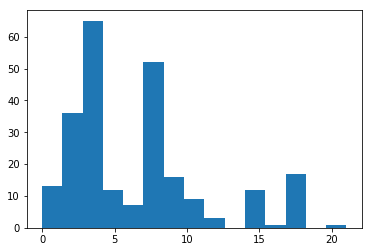

In [197]:
# Number of unique terrorists
num_terrorist = len(name_dict.keys())
print("Number of unique terrorist: {n:}".format(n=num_terrorist))

# Array of terrorist names 
all_names = np.array(list(name_dict.keys()))

# Initialize inverted adjacency matrix. Symmetric and unweighted by default.
A_inverted = np.zeros((num_terrorist, num_terrorist))
A_relations = np.zeros((num_terrorist, num_terrorist))

for n in range(n_nodes):
    temp = []
    for d, name in enumerate(list(name_dict.keys())):
        if n in list(name_dict.values())[d]:
            # collect all terrorist names that correspond to node n: will ALWAYS be at most length 2
            temp.append(list([name]))

    for k in range(len(temp)):
        for j in range(k, len(temp)):
            idx = np.where(all_names == temp[k])[0][0]
            idx2 = np.where(all_names == temp[j])[0][0]
            
            # create an edge between all terrorists that belonged to the same node in original graph
            A_inverted[idx,idx2] = 1
            A_inverted[idx2,idx] = 1
            
            # create a matrix which stores corresponding relations between terrorists             
            A_relations[idx,idx2] = int(labels[n])
            A_relations[idx2,idx] = int(labels[n])
            
plt.hist(np.sum(A_inverted,axis=1), bins=15)
plt.show()

### Largest Component of Inverted Graph

Number of disconnected components: 30


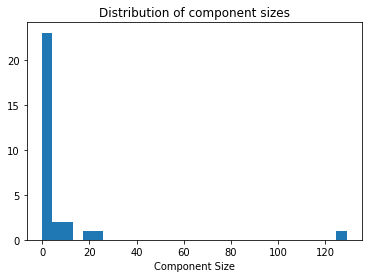

Size of inverted graph: 244
Size of largest component: 129


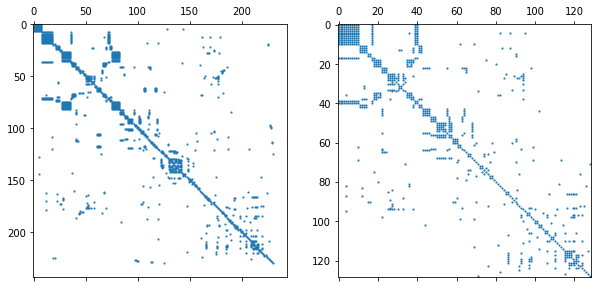

In [198]:
# Find the largest component
components = find_components(A_inverted)
largest_cc_inv, size = find_largest_component(components)

# Remove all-zero indices
zero_index = np.where(np.sum(largest_cc_inv, axis=0) == 0)[0]
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=0)
largest_cc_inv = np.delete(largest_cc_inv, zero_index, axis=1)
relations_largest_cc = np.delete(A_relations, zero_index, axis=0)
relations_largest_cc = np.delete(relations_largest_cc, zero_index, axis=1)
names_largest_cc = np.delete(all_names, zero_index)

print("Number of disconnected components: {d:}".format(d=len(components)))
deg_dist = []
for c in range(len(components)):
    deg_dist.append(num_nodes(components[c]))

plt.hist(deg_dist, bins=len(components))
plt.xlabel('Component Size')
plt.title('Distribution of component sizes')
plt.show()

print("Size of inverted graph: {s:}".format(s=num_terrorist))
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax1.spy(A_inverted, markersize=1)

print("Size of largest component: {s:}".format(s=size))
ax2 = fig.add_subplot(122)
ax2.spy(largest_cc_inv, markersize=1)

In [6]:
display = False
if display:
    for idx, name in enumerate(names):
        print(name)
        for i in range(A.shape[0]):
            if A[idx, i] == 1:
                print("\t"+str(names[i]))

In [7]:
def from_matrix_to_dict(mat):
    d = {}
    for index, value in np.ndenumerate(mat):
        d[index] = value
        
    return d

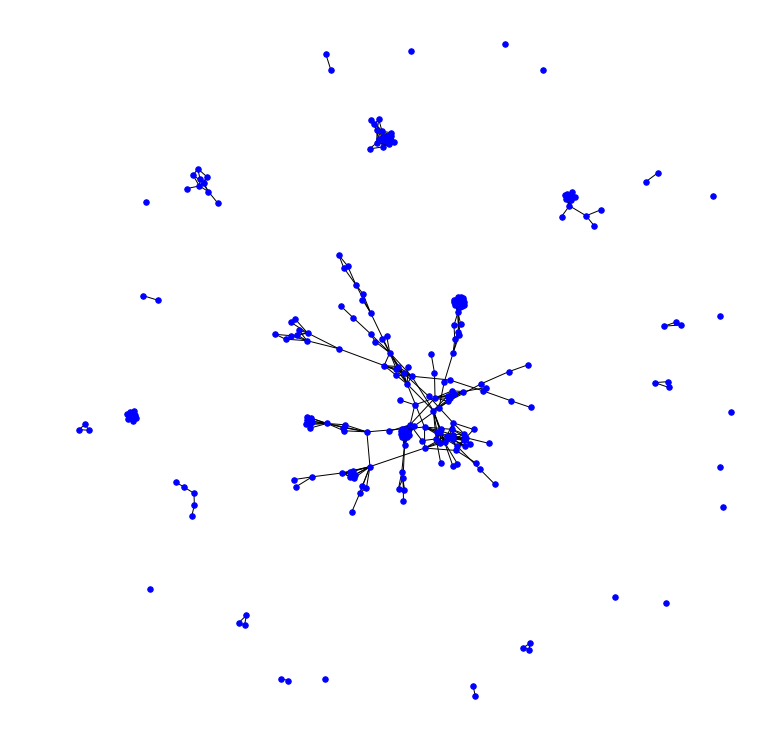

In [8]:
graph = nx.from_numpy_matrix(A_inverted)
d = from_matrix_to_dict(A_relations)
nx.set_edge_attributes(graph, d, 'relations')
plt.figure(1, figsize=(10, 10))
nx.draw(graph, pos=nx.spring_layout(graph), arrows=False, with_labels=False, node_size=30, node_color='b')
plt.show()

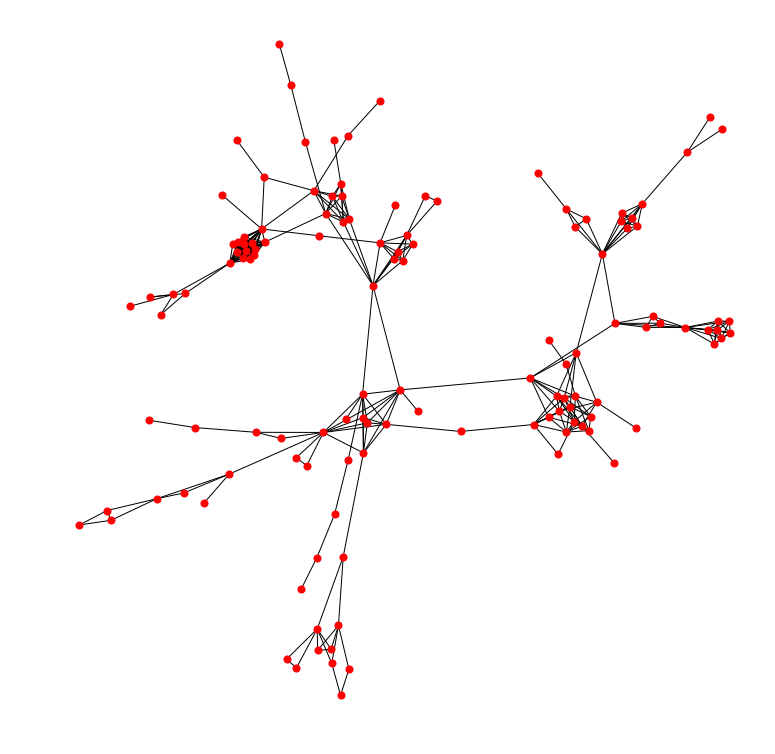

In [9]:
lcc_graph = nx.from_numpy_matrix(largest_cc_inv)
d = from_matrix_to_dict(relations_largest_cc)
nx.set_edge_attributes(lcc_graph, d, 'relations')
fig = plt.figure(1, figsize=(10, 10))
nx.draw(lcc_graph, pos=nx.spring_layout(lcc_graph), arrows=False, with_labels=False, node_size=50, node_color='r')
plt.show()

In [10]:
### GEPHI
nx.write_gml(lcc_graph, 'lcc_graph.gml')
nx.write_gml(graph, 'graph.gml')

# Identify Key Players for Fragmenting Network
In this section, we identify a set of key players that structurally destorys, or fragments, the network the most when removed. Metrics that help us evaluate this property include (all normalized except information entropy):
- count of number of disconnected components (+)
- F measure, count of number of pairs of nodes that are disconnected (+)
- Information entropy (+)
- Fd measure, modification of F measure which takes into account internal structure (+)

(+) = the higher, the more important that node is

Source: http://steveborgatti.com/papers/cmotkeyplayer.pdf

In [11]:
# compute value of different measures of fragmentation on the initial network
num_dis = num_disconnected_components(largest_cc_inv)

F = F_measure(largest_cc_inv)

entropy = information_entropy(largest_cc_inv)

Fd = Fd_measure(largest_cc_inv) # will display a progress bar

### Boxplots visualization of "fragmentation" measures

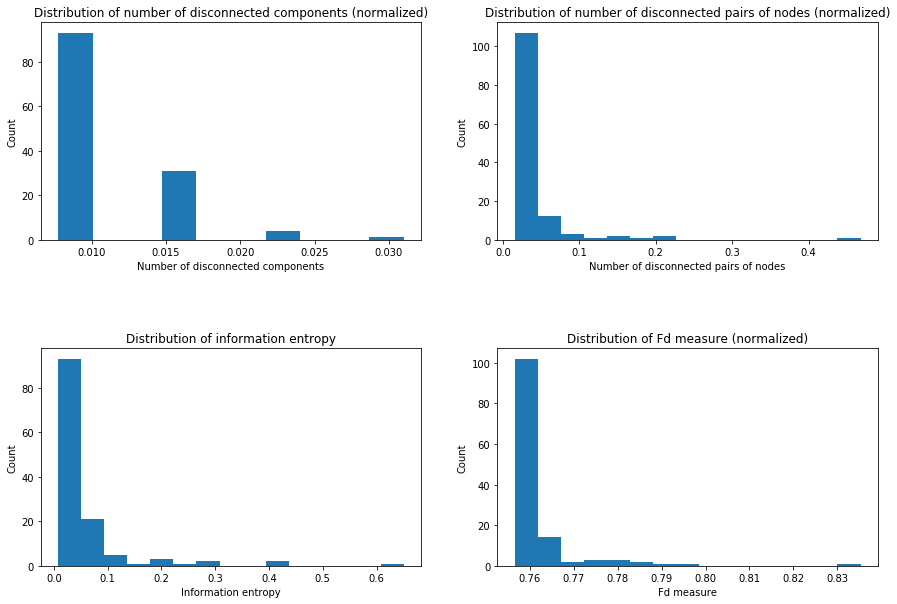

In [12]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax1.hist(num_dis, bins=10)
ax1.set_xlabel("Number of disconnected components")
ax1.set_ylabel("Count")
ax1.set_title("Distribution of number of disconnected components (normalized)")

ax2 = fig.add_subplot(222)
ax2.hist(F, bins=15)
ax2.set_xlabel("Number of disconnected pairs of nodes")
ax2.set_ylabel("Count")
ax2.set_title("Distribution of number of disconnected pairs of nodes (normalized)")

plt.subplots_adjust(hspace=0.5)

ax3 = fig.add_subplot(223)
ax3.hist(entropy, bins=15)
ax3.set_xlabel("Information entropy")
ax3.set_ylabel("Count")
ax3.set_title("Distribution of information entropy")

ax4 = fig.add_subplot(224)
ax4.hist(Fd, bins=15)
ax4.set_xlabel("Fd measure")
ax4.set_ylabel("Count")
ax4.set_title("Distribution of Fd measure (normalized)")
plt.show()

### Determine if any of the above measures are positively correlated

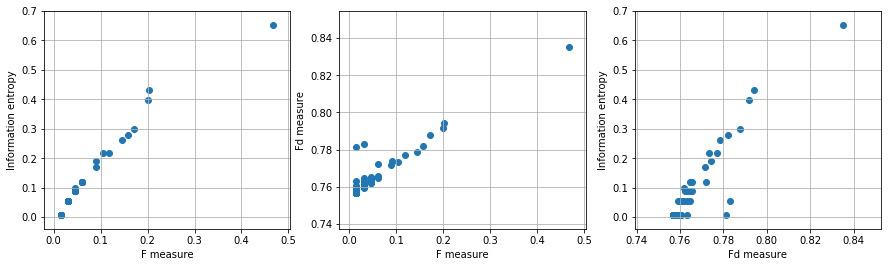

In [13]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(F, entropy)
ax1.set_xlabel("F measure")
ax1.set_ylabel("Information entropy")

ax2 = fig.add_subplot(132)
ax2.scatter(F, Fd)
ax2.set_xlabel("F measure")
ax2.set_ylabel("Fd measure")

ax3 = fig.add_subplot(133)
ax3.scatter(Fd, entropy)
ax3.set_xlabel("Fd measure")
ax3.set_ylabel("Information entropy")

ax1.grid()
ax2.grid()
ax3.grid()

# Identify Key Players for Information Flow
In this section, we identify a set of key players that are central for information flow within the network. This implies that without them, communication within the network is disrupted effectively. Metrics that help us evaluate this property include (all normalized):
- (group) degree centrality
- (group) closeness centrality
- (group) betweenness centrality

Source: http://steveborgatti.com/papers/cmotkeyplayer.pdf

In [199]:
# Degree centrality
degrees = np.sum(largest_cc_inv,axis=1) / (largest_cc_inv.shape[0]-1)

# convert adjacency matrix to networkx graph object
G = nx.from_numpy_matrix(largest_cc_inv)

# Closeness centrality
closeness = np.array(list(nx.closeness_centrality(G).values()))

# Betweenness centrality
between = np.array(list(nx.betweenness_centrality(G).values()))

### Boxplots visualization of centrality measures

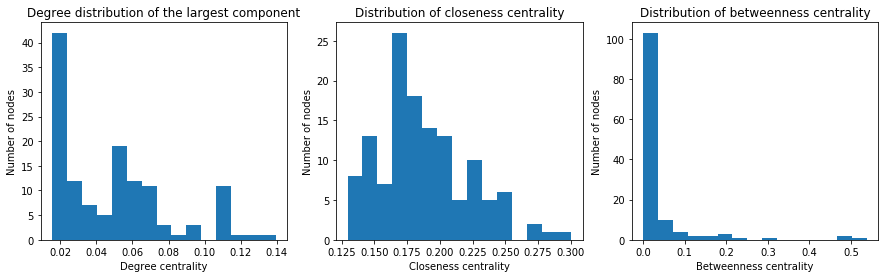

In [15]:
fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.hist(degrees, bins=15)
ax1.set_xlabel("Degree centrality")
ax1.set_ylabel("Number of nodes")
ax1.set_title("Degree distribution of the largest component")

ax2 = fig.add_subplot(132)
ax2.hist(closeness, bins=15)
ax2.set_xlabel("Closeness centrality")
ax2.set_ylabel("Number of nodes")
ax2.set_title("Distribution of closeness centrality")

ax3 = fig.add_subplot(133)
ax3.hist(between, bins=15)
ax3.set_xlabel("Betweenness centrality")
ax3.set_ylabel("Number of nodes")
ax3.set_title("Distribution of betweenness centrality")
plt.show()

### Determine if any of centrality measures are positively correlated

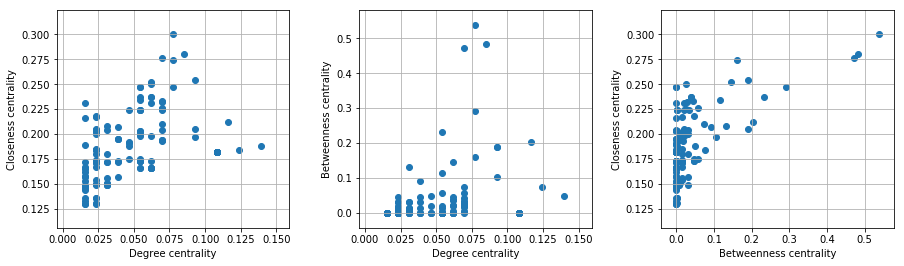

In [17]:
# Note that only betweenness and closeness centralities are (relatively) positively correlated

fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(131)
ax1.scatter(degrees, closeness)
ax1.set_xlabel("Degree centrality")
ax1.set_ylabel("Closeness centrality")

ax2 = fig.add_subplot(132)
ax2.scatter(degrees, between)
ax2.set_xlabel("Degree centrality")
ax2.set_ylabel("Betweenness centrality")

ax3 = fig.add_subplot(133)
ax3.scatter(between, closeness)
ax3.set_xlabel("Betweenness centrality")
ax3.set_ylabel("Closeness centrality")

plt.subplots_adjust(wspace=0.3)

ax1.grid()
ax2.grid()
ax3.grid()

# Greedy Optimization Algorithm

In [18]:
# Find key terrorist for fragmenting the network. 
set_kt, objective = find_key_terrorists_fragmentation(largest_cc_inv, relations_largest_cc)

Number of key terrorists for fragmentation: 3
List of the names of the key terrorists for fragmentation: 
 ['/2005/09/08/04:39:17' 'Zawahiri' 'Zain_al-Abidin_Mohd_Hussein']


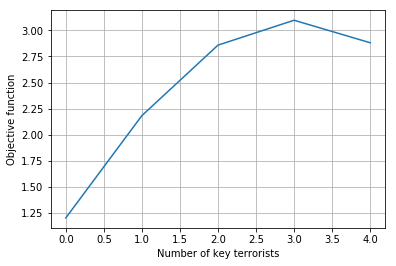

In [19]:
print("Number of key terrorists for fragmentation: {n:}".format(n=len(set_kt)-1))
print("List of the names of the key terrorists for fragmentation: \n", names_largest_cc[set_kt[:-1]])

plt.plot(objective)
plt.xlabel("Number of key terrorists")
plt.ylabel("Objective function")
plt.grid()
plt.show()

# Results

In [200]:
# First, identify the top three terrorists based on three centrality measures for comparison purposes
k = 3
top_k_degrees = np.sort(degrees)[-k:]
top_k_between = np.sort(between)[-k:]
top_k_closeness = np.sort(closeness)[-k:]

list_degrees = []
list_between = []
list_closeness = []
for i in range(k):
    list_degrees.append(np.where(degrees == top_k_degrees[i])[0][0])
    list_between.append(np.where(between == top_k_between[i])[0][0])
    list_closeness.append(np.where(closeness == top_k_closeness[i])[0][0])
    
adj_degree = largest_cc_inv
adj_between = largest_cc_inv
adj_closeness = largest_cc_inv
adj_frag = largest_cc_inv

# Remove these top individuals found by centrality measures
adj_degree = np.delete(largest_cc_inv, np.array(list_degrees), axis=0)
adj_degree = np.delete(adj_degree, np.array(list_degrees), axis=1)

adj_between = np.delete(largest_cc_inv, list_between, axis=0)
adj_between = np.delete(adj_between, list_between, axis=1)

adj_closeness = np.delete(largest_cc_inv, list_closeness, axis=0)
adj_closeness = np.delete(adj_closeness, list_closeness, axis=1)

adj_frag = np.delete(largest_cc_inv, set_kt[:-1], axis=0)
adj_frag = np.delete(adj_frag, set_kt[:-1], axis=1)

In [201]:
def evaluate_fragmentation(original, adjacency):
    """
    Given original adjacency matrix, measure how fragmented "adjacency" is in comparison
    """
    # Number of disconnected components
    
    N = original.shape[0]
    components = find_components(adjacency)
    
    
    sum_Sk = 0
    numer = 0
    for i in range(len(components)):
        zero_index = np.where(np.sum(components[i], axis=0) == 0)[0]
        components[i] = np.delete(components[i], zero_index, axis=0)
        components[i] = np.delete(components[i], zero_index, axis=1)
        
        if len(components[i]) == 0: continue
            
        # F measure
        Sk = num_nodes(components[i])
        sum_Sk += (Sk * (Sk-1))
        
        # Information entropy
        numer += -(Sk / N)*np.log(Sk/N)
        
    Fmeasure = 1 - sum_Sk / (N*(N-1))
    
    # Number of edges cut
    E = np.count_nonzero(original) / 2
    edges_cut = np.count_nonzero(adjacency) / 2
    
    return Fmeasure, numer, len(components), (E - edges_cut)

# Compared to the original adjacency, measure how fragmented the new adjacency is
Fdegrees, ent_degrees, disc_degrees, edges_degrees = evaluate_fragmentation(largest_cc_inv, adj_degree)
Fbetween, ent_between, disc_between, edges_between = evaluate_fragmentation(largest_cc_inv, adj_between)
Fcloseness, ent_closeness, disc_closeness, edges_closeness = evaluate_fragmentation(largest_cc_inv, adj_closeness)
Ffrag, ent_frag, disc_frag, edges_frag = evaluate_fragmentation(largest_cc_inv, adj_frag)

In [202]:
print(Fdegrees, ent_degrees, disc_degrees, edges_degrees)
print(Fbetween, ent_between, disc_between, edges_between)
print(Fcloseness, ent_closeness, disc_closeness, edges_closeness)
print(Ffrag, ent_frag, disc_frag, edges_frag)

0.27919089147286824 0.5159333815786159 4 44.5
0.4973352713178295 0.7013520940774866 3 26.5
0.4973352713178295 0.7013520940774866 3 26.5
0.6917393410852712 1.3547301103304514 7 33.5


In [206]:
F2 = F_measure(adj_frag)
IE2 = information_entropy(adj_frag)
Fd2 = Fd_measure(adj_frag)

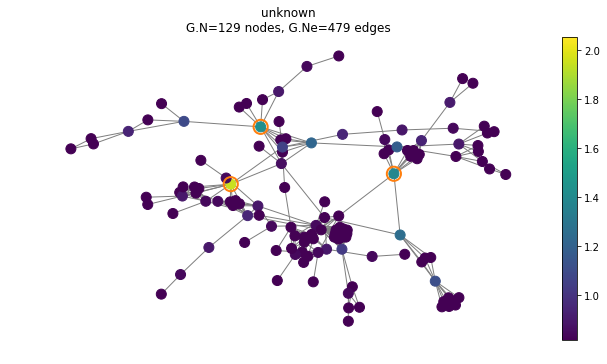

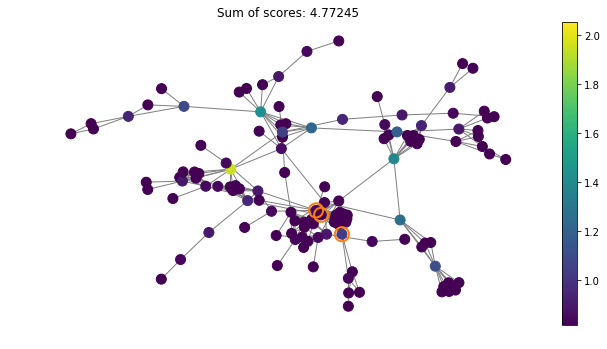

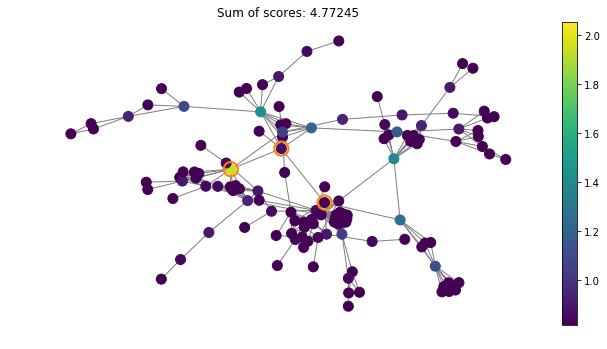

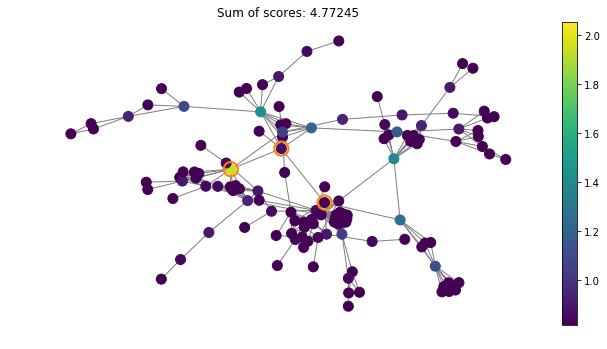

In [219]:
# Create pygsp graph for visualization
G_frag = pg.graphs.Graph(largest_cc_inv)
G_frag.set_coordinates('spring')

frag = F + entropy + Fd

# Highlight algorithm's findings
fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[0])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=set_kt[:-1])
#title = r'Sum of scores: {}'.format(round(np.sum(frag[set_kt[:-1]]), 5))
#_ = ax.set_title(title)
ax.set_axis_off()

# Highlight top individuals for degree centrality
fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[0])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=list_degrees)
title = r'Sum of scores: {}'.format(round(np.sum(frag[set_kt[:-1]]), 5))
_ = ax.set_title(title)
ax.set_axis_off()

# Highlight top individuals for betweenness centrality
fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[0])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=list_between)
title = r'Sum of scores: {}'.format(round(np.sum(frag[set_kt[:-1]]), 5))
_ = ax.set_title(title)
ax.set_axis_off()

# Highlight top individuals for closeness centrality
fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[0])
G_frag.plot_signal(frag, colorbar=True, ax=ax, highlight=list_closeness)
title = r'Sum of scores: {}'.format(round(np.sum(frag[set_kt[:-1]]), 5))
_ = ax.set_title(title)
ax.set_axis_off()

2019-01-17 23:16:04,639:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


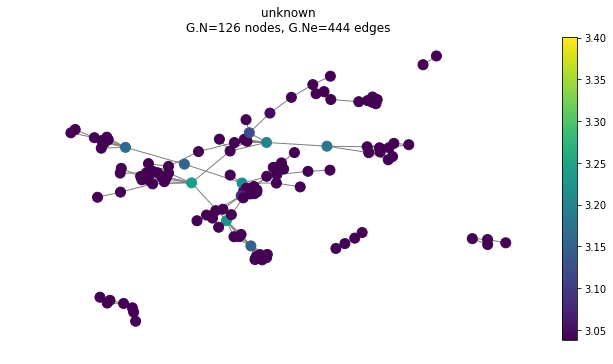

In [217]:
# Post-fragmentation network
G_frag2 = pg.graphs.Graph(adj_frag)
G_frag2.set_coordinates('spring')

frag2 = F2 + IE2 + Fd2

fig = plt.figure(figsize=(18, 21))
ax = plt.subplot(gs[0]) 
G_frag2.plot_signal(frag2, colorbar=True, ax=ax)
#title = r'Sum of scores: {}'.format(round(np.sum(frag[set_kt[:-1]]), 5))
#_ = ax.set_title(title)
ax.set_axis_off()

### TO DO:

Tasks to do: 

    - Exploration of the network: 
        - Give info (numbers) of the current network. What's important from it? Why can we work with the largest component? Whatever useful info we can say about it.

    - Network Fragmentation:
        - Display network before fragmentation and identify (color, tag, etc.) the key players.
        - Display network without key players.
        - Give information about the "destruction" of the network.
            - How many components do we have now?
            - How many links are removed? What's the type of relation is being broken (from the initial information of the dataset)
            - How hard is it to get to these key players? (Give some info about them are their neighborhood)
            
     - Information flow:
         - Identify key players in information flow. --> Run optimization algorithm on information metrics, find best/most useful metric
         - Study diffusion on initial network. 
         - Study diffusion in the network when information is fed through these guys. 
         - Give information about these key players